---

# Lib


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from xgboost import XGBClassifier
import optuna

---

# Read file


In [21]:
df_train = pd.read_csv("../data/processed/train.csv", encoding="utf-8")
df_val = pd.read_csv("../data/processed/val.csv", encoding="utf-8")

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    3592 non-null   object
 1   model    3592 non-null   object
 2   version  2489 non-null   object
 3   year     3592 non-null   int64 
 4   segment  3592 non-null   object
 5   comment  3592 non-null   object
 6   label    3592 non-null   object
dtypes: int64(1), object(6)
memory usage: 196.6+ KB


In [23]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    1040 non-null   object
 1   model    1040 non-null   object
 2   version  718 non-null    object
 3   year     1040 non-null   int64 
 4   segment  1040 non-null   object
 5   comment  1040 non-null   object
 6   label    1040 non-null   object
dtypes: int64(1), object(6)
memory usage: 57.0+ KB


---

# Labels


## Train


In [24]:
matrix_labels_train = df_train["label"]

In [25]:
matrix_labels_train.head()

0    negative
1    negative
2    positive
3    positive
4    negative
Name: label, dtype: object

In [26]:
print(f"Number of labels: {len(matrix_labels_train.unique())}")
print(f"Labels: {matrix_labels_train.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


## Val


In [27]:
matrix_labels_val = df_val["label"]

In [28]:
matrix_labels_val.head()

0    negative
1    negative
2    positive
3    positive
4    negative
Name: label, dtype: object

In [29]:
print(f"Number of labels: {len(matrix_labels_val.unique())}")
print(f"Labels: {matrix_labels_val.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


---

# Train, val split


In [30]:
# Train
X_train = df_train[["comment"]]
y_train = matrix_labels_train

# Validation
X_val = df_val[["comment"]]
y_val = matrix_labels_val

In [31]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train).astype(np.int64)

---

# Vectorize


In [32]:
vec = TfidfVectorizer(
    analyzer="char",
    min_df=3,
    max_df=0.95,
    ngram_range=(3, 5),
    max_features=30000,
)

In [33]:
# Fit TF-IDF on training and transform train/test
X_train_vec = vec.fit_transform(X_train["comment"])
X_val_vec = vec.transform(X_val["comment"])

In [34]:
print(f"Train shape: {X_train_vec.shape}")
print(f"Test shape: {X_val_vec.shape}")
print(f"Vocabulary size: {len(vec.get_feature_names_out())}")

Train shape: (3592, 28463)
Test shape: (1040, 28463)
Vocabulary size: 28463


---

# Load Model


In [35]:
# Define a StratifiedKFold splitters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

---

## Svm


### Model


In [36]:
# SVC
svc = SVC(random_state=42)

In [ ]:
# hyperparameters
param_grid = {
    "C": np.linspace(1, 10, 20),
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto"],
}

In [38]:
scoring = "f1_macro"

# Grid search
grid_svm = GridSearchCV(
    svc,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1,
)

In [39]:
# Fit
grid_svm.fit(X_train_vec, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


,estimator,SVC(random_state=42)
,param_grid,"{'C': array([2. ..., 8. ]), 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(4.842105263157895)


In [40]:
print("Best params:")
for item in grid_svm.best_params_.items():
    print(f"\t{item[0]}: {item[1]}")
print()
print(f"Best CV score (f1): {grid_svm.best_score_:.2f}")

Best params:
	C: 4.842105263157895
	gamma: scale
	kernel: linear

Best CV score (f1): 0.50


### Eval


In [41]:
# Predict
y_pred = grid_svm.predict(X_val_vec)
y_pred = le.inverse_transform(y_pred)

In [42]:
# Compute metrics
metrics = {
    "accuracy_score": accuracy_score(y_val, y_pred),
    "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
}

matrix_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["score"])

In [43]:
matrix_metrics.round(4)

,score
accuracy_score,0.6510
precision_macro,0.5108
recall_macro,0.5068
f1_macro,0.5052


In [44]:
# Classified report
print(
    classification_report(
        y_val.values, y_pred, target_names=le.classes_, zero_division=0
    )
)

              precision    recall  f1-score   support

    negative       0.64      0.67      0.66       410
     neutral       0.18      0.10      0.13       105
    positive       0.71      0.74      0.73       525

    accuracy                           0.65      1040
   macro avg       0.51      0.51      0.51      1040
weighted avg       0.63      0.65      0.64      1040



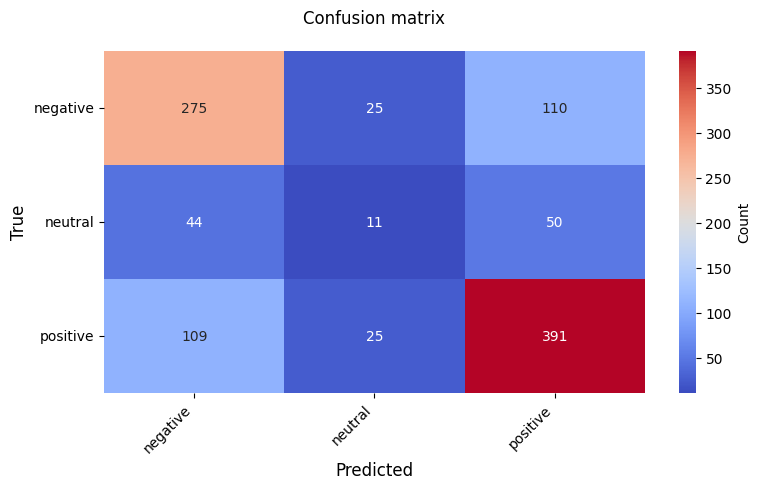

In [45]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion matrix", pad=20)
plt.ylabel("True", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Test


In [46]:
df_test = pd.read_csv("../data/raw/test.csv")
df_test_predict = df_test.copy()
df_test_predict.head()

,brand,model,version,year,segment,comment,label
0,geely,coolray,flagship,2025,suv,"Xe Geely giờ uy tín hơn, bán chạy ở nhiều nước.",positive
1,nissan,kicks,e-powers,2025,suv,Ngáo giá nên ế có thế thôi,negative
2,huyndai,accent,NaN,2024,sedan,"nhìn cứng cáp, hiện đại quá",positive
3,toyota,yaris cross,máy xăng,2024,suv,"Yari Cross trang bị an toàn hơn, bền bỉ hơn, b...",positive
4,skoda,slavia,style,2025,sedan,Riêng quả gạt mưa + gương chống chói tự động +...,positive


In [47]:
# Try prediction on some samples
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples)
preds = grid_svm.best_estimator_.predict(samples_vec)
preds = le.inverse_transform(preds)

for i, (text, pred) in enumerate(zip(samples, preds), start=1):
    df_test_predict.loc[i - 1, "predicted_label"] = pred

In [48]:
df_test_predict[["segment", "label", "predicted_label"]].groupby(
    ["segment", "label", "predicted_label"]
).value_counts()

segment  label     predicted_label
sedan    negative  negative            36
                   neutral              6
                   positive            16
         neutral   negative            11
                   neutral              4
                   positive             4
         positive  negative            32
                   neutral              8
                   positive            60
suv      negative  negative           105
                   neutral              5
                   positive            29
         neutral   negative            17
                   neutral              4
                   positive            10
         positive  negative            60
                   neutral              4
                   positive            89
Name: count, dtype: int64

---

## Logistic regression


### Model


In [49]:
log = LogisticRegression(random_state=42, max_iter=1000)

In [ ]:
# hyperparameters
param_grid = {
    "C": np.linspace(5, 10, 10),
    "penalty": ["l1", "l2", "elasticnet"],
    "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
}

In [55]:
scoring = "f1_macro"

# Grid search
grid_log = GridSearchCV(
    log,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv_splitter,
    n_jobs=-1,
    verbose=0,
)

In [56]:
grid_log.fit(X_train_vec, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': array([ 5. ... 20. ]), 'penalty': ['l1', 'l2', ...], 'solver': ['lbfgs', 'liblinear', ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [57]:
print("Best params:")
for item in grid_log.best_params_.items():
    print(f"\t{item[0]}: {item[1]}")
print()
print(f"Best CV score (f1): {grid_log.best_score_:.2f}")

Best params:
	C: 8.947368421052632
	penalty: l1
	solver: saga

Best CV score (f1): 0.50


### Eval


In [58]:
# Predict
y_pred = grid_log.predict(X_val_vec)
y_pred = le.inverse_transform(y_pred)

In [59]:
# Compute metrics
metrics = {
    "accuracy_score": accuracy_score(y_val, y_pred),
    "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
}

matrix_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["score"])

In [60]:
matrix_metrics.round(4)

,score
accuracy_score,0.6692
precision_macro,0.5390
recall_macro,0.5186
f1_macro,0.5183


In [61]:
# Classified report
print(
    classification_report(
        y_val.values, y_pred, target_names=le.classes_, zero_division=0
    )
)

              precision    recall  f1-score   support

    negative       0.66      0.67      0.66       410
     neutral       0.25      0.10      0.15       105
    positive       0.71      0.78      0.74       525

    accuracy                           0.67      1040
   macro avg       0.54      0.52      0.52      1040
weighted avg       0.64      0.67      0.65      1040



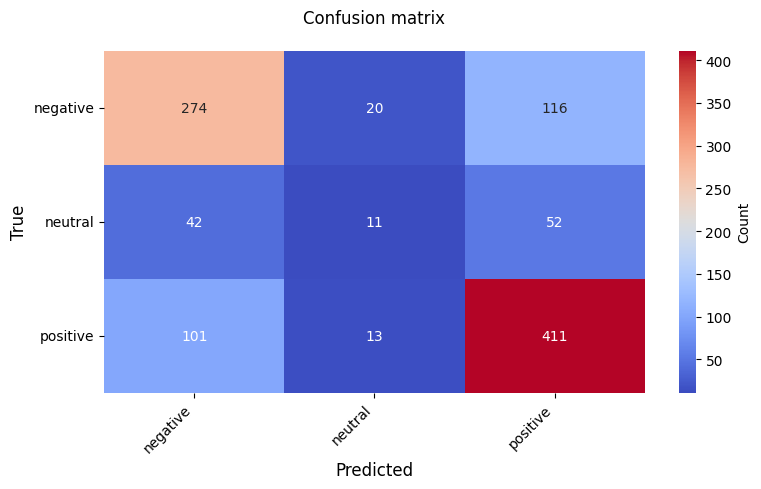

In [62]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion matrix", pad=20)
plt.ylabel("True", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Test


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/test.csv")
df_test_predict = df_test.copy()
df_test_predict.head()

In [ ]:
# Try prediction
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples)
preds = grid_svm.best_estimator_.predict(samples_vec)
preds = le.inverse_transform(preds)

for i, (text, pred) in enumerate(zip(samples, preds), start=1):
    df_test_predict.loc[i - 1, "predicted_label"] = pred

In [ ]:
df_test_predict[["segment", "label", "predicted_label"]].groupby(
    ["segment", "label", "predicted_label"]
).value_counts()

---

## Xgboost


### Model


In [ ]:
def objective(trial):

    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "random_state": 42,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
    }

    skf = cv_splitter
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train_vec, y_train):
        X_tr, X_val = X_train_vec[train_idx], X_train_vec[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [ ]:
study = optuna.create_study(direction="maximize", study_name="xgb_f1_macro")
study.optimize(objective, n_trials=10)

In [ ]:
print("Best f1-macro:", study.best_value)
print("Best trial:", study.best_trial.number)

In [ ]:
best_params = study.best_params

print("Best params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

In [ ]:
# Build final model with best hyperparameters
best_params.update(
    {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "random_state": 42,
    }
)

xgb_model = XGBClassifier(**best_params)

In [ ]:
xgb_model.fit(X_train_vec, y_train)

### Eval


In [ ]:
y_pred = xgb_model.predict(X_val_vec)
y_pred = le.inverse_transform(y_pred)

In [ ]:
# Compute metrics
metrics = {
    "accuracy_score": accuracy_score(y_val, y_pred),
    "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
}

matrix_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["score"])

In [ ]:
matrix_metrics.round(4)

In [ ]:
# Classified report
print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion matrix", pad=20)
plt.ylabel("True", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Test


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/test.csv")
df_test_predict = df_test.copy()
df_test_predict.head()

In [ ]:
# Try prediction
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples)
preds = grid_svm.best_estimator_.predict(samples_vec)
preds = le.inverse_transform(preds)

for i, (text, pred) in enumerate(zip(samples, preds), start=1):
    df_test_predict.loc[i - 1, "predicted_label"] = pred

In [ ]:
df_test_predict[["segment", "label", "predicted_label"]].groupby(
    ["segment", "label", "predicted_label"]
).value_counts()